In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [12]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


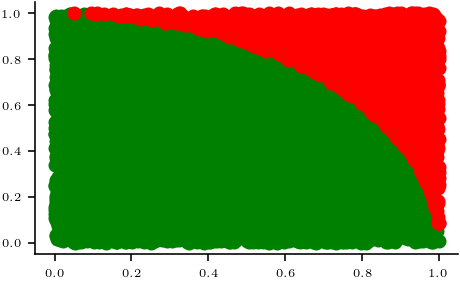

In [14]:
# Monte Carlo simulation for value of pi

def mc_pi(n):
    x = torch.rand(n)
    y = torch.rand(n)
    f = x**2 + y**2 < 1
    ratios = f.float() * 4
    return x, y, f, ratios

def mc_pi_plot(n):
    x, y, f, ratios = mc_pi(n)
    #plt.figure(figsize=(5,5))
    # Green points are inside the circle, red points are outside
    plt.scatter(x[f], y[f], color='g')
    plt.scatter(x[~f], y[~f], color='r')
    plt.show()

mc_pi_plot(10000)

In [15]:
# Show the value of pi as a function of the number of points

n = 10000
x, y, f, ratios = mc_pi(n)


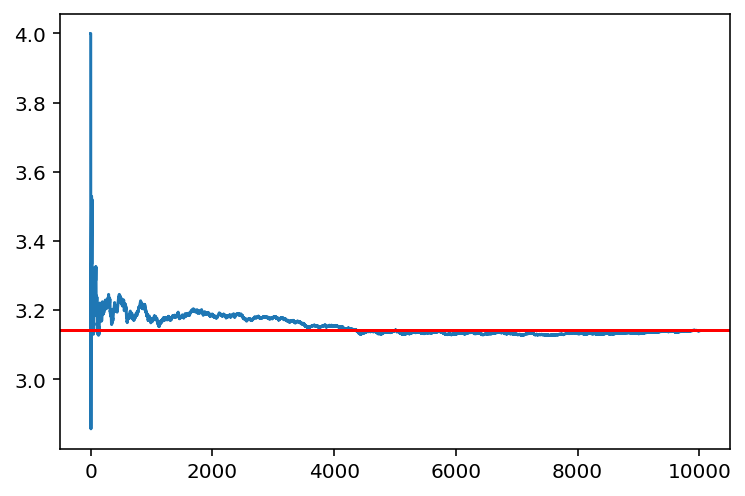

In [4]:
# cumulative sum of ratios
pis = ratios.cumsum(0)/torch.arange(1, n+1)
plt.plot(pis)
plt.axhline(np.pi, color='r')

In [5]:
torch.std(pis, dim=0)

tensor(0.0330)

In [6]:
pis.shape

torch.Size([10000])

In [7]:
pis.shape

torch.Size([10000])

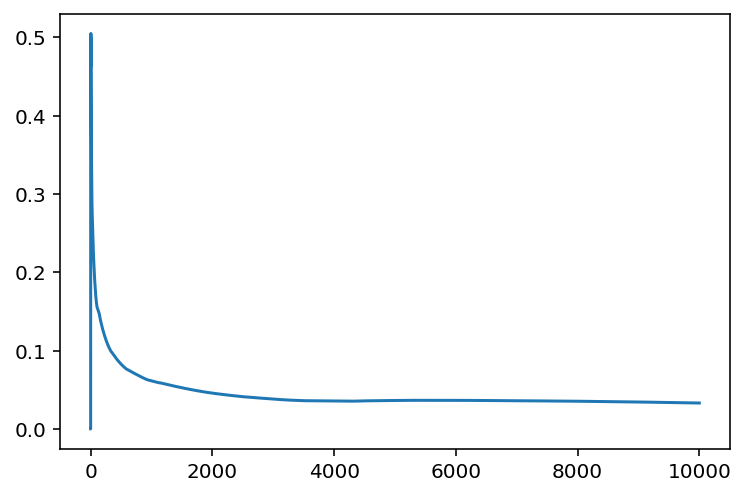

In [8]:
stds = []
for i in range(1, n+1):
    stds.append(pis[:i].std())
plt.plot(stds)


### Gaussian Integral

\begin{equation}
I = \int_{-\infty}^{\infty} e^{-\frac{x^2}{2}} dx
\end{equation}

Normal distribution:
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}

For $\mu=0$ and $\sigma=1$:
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}
\end{equation}

In [4]:
## Rejection sampling

import torch.distributions as D

mix = D.Categorical(torch.ones(5,))
comp = D.Normal(torch.randn(5,), torch.rand(5,))
mog = D.MixtureSameFamily(mix, comp)


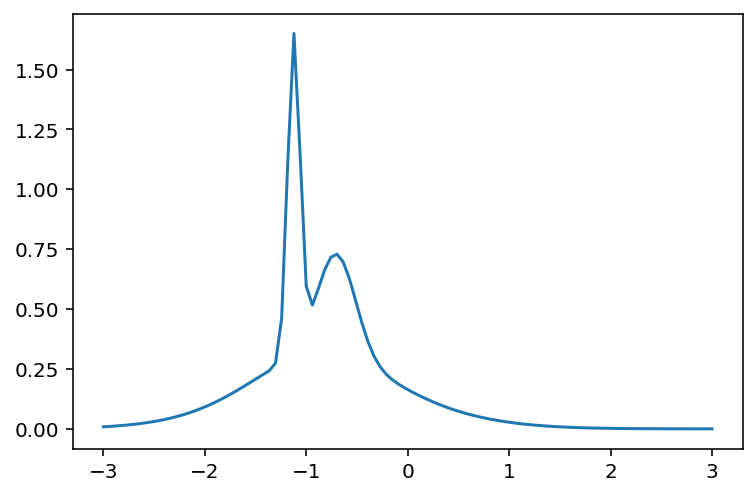

In [5]:
# Plot the mixture of Gaussians
xs = torch.linspace(-3, 3, 100)
plt.plot(xs, mog.log_prob(xs).exp())

In [6]:
# Take a proposal distribution q(x) = N(0, 1)
q = D.Normal(0, 1)

In [7]:
# Let $M$ be a constant such that $M \geq \frac{p(x)}{q(x)} \forall x$.

M = torch.max(mog.log_prob(xs) - q.log_prob(xs)).exp()
M

tensor(7.7566)

In [8]:
torch.argmax(mog.log_prob(xs) - q.log_prob(xs))

tensor(31)

In [9]:
xs[31]

tensor(-1.1212)

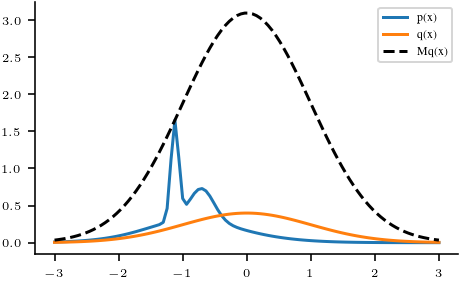

In [23]:
def plot_base():
    # Plot the mixture of Gaussians
    
    plt.legend()
plot_base()

In [123]:
# Sample from the proposal distribution and accept or reject.
# Accepted shown in green, rejected shown in red.

def plot_sample(x, show_q = False,
                show_Mq = False,
                show_sample=False, 
                show_vline = False,
                  show_px=False, 
                  show_Mqx=False, 
                  show_uMqx=False, 
                  show_accept=False):
    xs = torch.linspace(-3, 3, 100)
    plt.plot(xs, mog.log_prob(xs).exp(), label='p(x)')
    plt.title("Target distribution p(x)")

    if show_q:
        # Plot the proposal distribution
        plt.plot(xs, q.log_prob(xs).exp(), label='q(x)')
        plt.title("Proposal distribution q(x)")

    if show_Mq:
        # Plot the scaled proposal distribution
        plt.plot(xs, M * q.log_prob(xs).exp(), label='Mq(x)', color='k', linestyle='--')
        plt.title("Scaled proposal distribution Mq(x)")
    if show_sample:
        plt.scatter(x, 0,marker='x', color='k', label = r"$x\sim q(x)$")
        plt.title("Sample from proposal distribution")
    
    if show_vline:
        plt.axvline(x, color='y', linestyle='--')
        plt.title("Sample from proposal distribution")

    if show_px:
        plt.scatter(x, mog.log_prob(x).exp(), color='b', label=r"$p(x)$")
        plt.title("Evaluate target distribution p(x) at sample x")

    
    if show_Mqx:
        plt.scatter(x, M * q.log_prob(x).exp(), color='k', label=r"$Mq(x)$")
        plt.title("Evaluate scaled proposal distribution Mq(x) at sample x")
    
    if show_uMqx:
        torch.manual_seed(0)
        u = torch.rand(1)
        plt.scatter(x, u * M * q.log_prob(x).exp(), label=r"$uMq(x)$", color='purple')
    
    if show_accept:
        if u * M * q.log_prob(x).exp() < mog.log_prob(x).exp():
            plt.scatter(x, 0, label=r"Accepted", color='g')
        else:
            plt.scatter(x, 0, label=r"Rejected", color='r')


    
    plt.ylim(-.05, 4.0)
    plt.legend()
    plt.savefig(f"figures/sampling/rejection-sampling-{x}-{show_q}-{show_Mq}-{show_sample}-{show_vline}-{show_px}-{show_Mqx}-{show_uMqx}-{show_accept}.pdf", bbox_inches='tight')


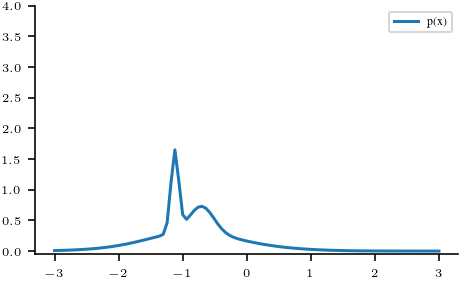

In [124]:
plot_sample(torch.tensor(-1.0))

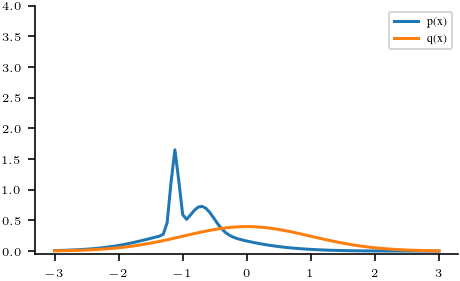

In [125]:
plot_sample(torch.tensor(-1.0), show_q=True)

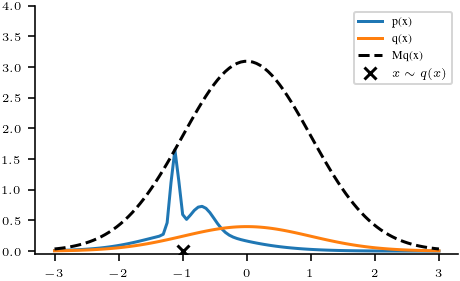

In [116]:
plot_sample(torch.tensor(-1.0), show_sample=True)

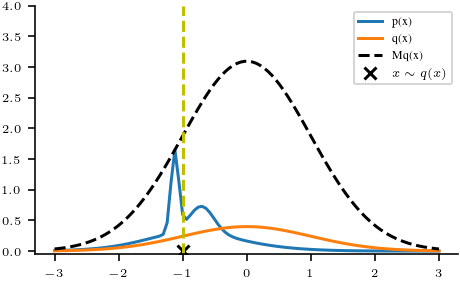

In [117]:
plot_sample(torch.tensor(-1.0), show_sample=True, show_vline=True)

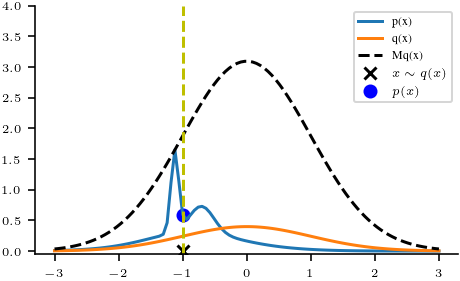

In [118]:
plot_sample(torch.tensor(-1.0), show_sample=True, show_vline=True, show_px=True)

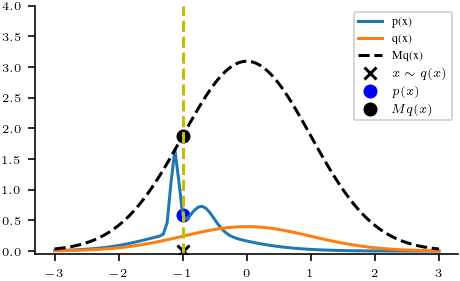

In [119]:
plot_sample(torch.tensor(-1.0), show_sample=True, show_vline=True, show_px=True, show_Mqx=True)

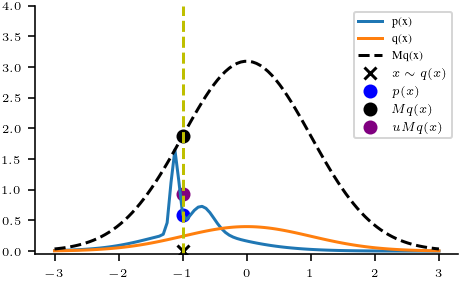

In [120]:
plot_sample(torch.tensor(-1.0), show_sample=True, show_vline=True, show_px=True, show_Mqx=True, show_uMqx=True)

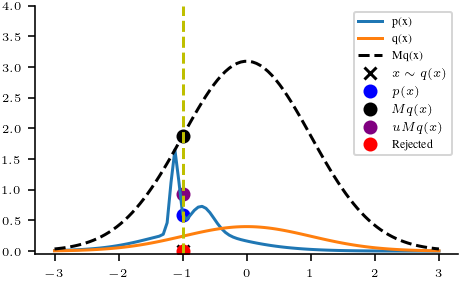

In [121]:
plot_sample(torch.tensor(-1.0), show_sample=True, show_vline=True, show_px=True, show_Mqx=True, show_uMqx=True, show_accept=True)

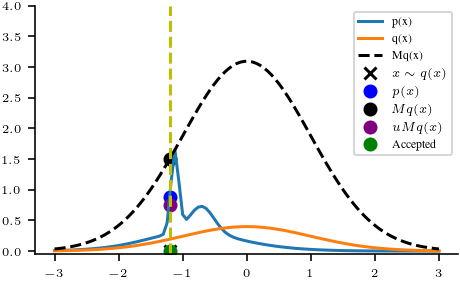

In [122]:
plot_sample(torch.tensor(-1.2), show_sample=True, show_vline=True, show_px=True, show_Mqx=True, show_uMqx=True, show_accept=True)